In [1]:
import torch
from torchtext.datasets import text_classification
import pandas as pd
import numpy as np
import pickle
import os
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import time
from torch.utils.data.dataset import random_split


## Data paths : creating the files for training and testing ##

In [2]:
if not os.path.isdir('./.data'):
    os.mkdir('./.data')
#train_dataset, test_dataset = text_classification.DATASETS['AG_NEWS'](root='./.data', ngrams=NGRAMS, vocab=None)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


/home/sebastien/.local/lib/python3.6/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


In [3]:
# we take as input a file with title, article and label, and we convert it into another file that respects the need of preprocessing (csv, delimiter=",", columns article and label necessary)

initial_data_path="./data/initial_data.csv"


In [4]:
def preprocess_data(file_path, testing=False):
    data=pd.read_csv(initial_data_path, delimiter=",")
    nb=data.shape[0]
    ghost_col=[0]*nb
    articles=data['article']
    labels=list(data['label'])
    for i in range(len(labels)):
        if labels[i]=="am":
            labels[i]=1
        elif labels[i]=="nam":
            labels[i]=0
        else:
            labels[i]=0

    data2=pd.DataFrame(columns=[])
    data2.insert(0, "article", articles, True)
    data2.insert(1, "label", labels, True)
    print(data2.head())
    print(data2.tail())

    #and the  we store it the new file
    data2 = data2.rename(columns = {'Unnamed: 0':'index'})
    
    data2.to_csv("./data/data_intermediary.csv", sep=",", index_label="index")
    return

In [5]:
# then we split the data
def split_data_for_train_test():
    data=pd.read_csv("./data/data_intermediary.csv", sep=",", index_col="index")
    data=data.sample(frac = 1)
    nb_elems=data.shape[0]
    train_data=data.iloc[:int(nb_elems*0.8)]
    test_data=data.iloc[int(nb_elems*0.8):]
    print(train_data.shape)
    print(test_data.shape)
    print(train_data.columns)
    print(train_data.head)
    print(test_data.head)
    train_data.to_csv("./data/train_2.csv", sep=",", index_label="index")
    test_data.to_csv("./data/test_2.csv", sep=",", index_label="index")
    return


In [6]:
preprocess_data(initial_data_path)
split_data_for_train_test()

                                             article  label
0  Bernie Madoff, who is scheduled to be sentence...      1
1  Published\n\nOne of the world's leading fund m...      1
2       'webPage': {'inLanguages': [{'code': 'en'}]}      1
3  WASHINGTON (AP) â An American security contr...      1
4  A senior figure in the Bitcoin Foundation, whi...      1
                                                article  label
1082  The signing of the deal normalising relations ...      0
1083  Slipping a $20 bill to the woman at the DMV mi...      0
1084  As fraudsters continually refine their techniq...      0
1085  Dr. Arif Alvi was born in 1949 and completed h...      0
1086  KUALA LUMPUR, Nov 2  Life was fine for vetera...      0
(869, 2)
(218, 2)
Index(['article', 'label'], dtype='object')
<bound method NDFrame.head of                                                  article  label
index                                                          
39          'webPage': {'inLanguages': [{'

In [7]:
train_csv_path="./data/train_2.csv"
test_csv_path="./data/test_2.csv" #this contains the testing data: only columns "article" and "label" (and possibly others)



## Preprocessing ##

In [8]:
import logging
import torch
import io
from torchtext.utils import download_from_url, extract_archive, unicode_csv_reader
from torchtext.data.utils import ngrams_iterator
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torchtext.vocab import Vocab
from tqdm import tqdm
from  torchtext.datasets.text_classification import _csv_iterator, _create_data_from_iterator, TextClassificationDataset


NGRAMS=2

In [9]:
def _csv_iterator(data_path, ngrams, yield_cls=False, label=-1):
    tokenizer = get_tokenizer("basic_english")
    data=pd.read_csv(data_path, delimiter=",")
    for index, row in data.iterrows():
        
        tokens = ' '.join([str(row["article"])])
        #print(row[5])
        tokens=tokenizer(tokens)
        if yield_cls:
            yield row[0], row["label"], ngrams_iterator(tokens, ngrams)
        else:
            yield ngrams_iterator(tokens, ngrams)


def _create_data_from_iterator(vocab, iterator, include_unk):
    data = []
    labels = []
    with tqdm(unit_scale=0, unit='lines') as t:
        for index, cls, tokens in iterator:
            if include_unk:
                tokens = torch.tensor([vocab[token] for token in tokens])
            else:
                token_ids = list(filter(lambda x: x is not Vocab.UNK, [vocab[token] for token in tokens]))
                tokens = torch.tensor(token_ids)
            if len(tokens) == 0:
                logging.info('Row contains no tokens.')
            data.append((index, cls, tokens))
            labels.append(cls)
            t.update(1)
    return data, set(labels)



def create_iterator_from_file_for_testing(vocab, ngrams, data, include_unk=False):
    #each element contains text and label
    article_index=1
    label_index=2
    datas = []
    labels = []
    tokenizer = get_tokenizer("basic_english")
    
    with tqdm(unit_scale=0, unit='lines') as t:
        for index, row in data.iterrows():
            
            tokens = ' '.join([str(row['article'])])
            tokens=tokenizer(tokens)
            cls=int(row['label'])
            
            index=row.name
            
            if include_unk:
                tokens = torch.tensor([vocab[token] for token in tokens])
            else:
                token_ids = list(filter(lambda x: x is not Vocab.UNK, [vocab[token] for token in tokens]))
                tokens = torch.tensor(token_ids)
            if len(tokens) == 0:
                logging.info('Row contains no tokens.')
            
            datas.append((index, cls, tokens))
            labels.append(cls)
            t.update(1)
    return datas, set(labels)


#1: am
#0: nam
def setup_datasets(train_csv_path, test_csv_path, include_unk=False):
    iterator=_csv_iterator(train_csv_path, NGRAMS)
    vocab = build_vocab_from_iterator(iterator)
    train_data, train_labels = _create_data_from_iterator(vocab, _csv_iterator(train_csv_path, NGRAMS, yield_cls=True, label=0), include_unk)
    test_data, test_labels = _create_data_from_iterator(vocab, _csv_iterator(test_csv_path, NGRAMS, yield_cls=True, label=0), include_unk)


    return TextClassificationDataset(vocab, train_data, train_labels), TextClassificationDataset(vocab, test_data, test_labels), vocab

#this is the version where we don't have the tarining data
def setup_datasets_testing(vocab, test_csv_path, include_unk=False):
    data=pd.read_csv(test_csv_path, delimiter=",")
    test_data, test_labels=create_iterator_from_file_for_testing(vocab, NGRAMS, data)
    #test_data, test_labels = _create_data_from_iterator(vocab, _csv_iterator(test_csv_path, NGRAMS, yield_cls=True, label=0), include_unk)


    return TextClassificationDataset(vocab, test_data, test_labels), vocab


def setup_datasets_testing_from_df(vocab, df, include_unk=False):
    test_data, test_labels=create_iterator_from_file_for_testing(vocab, NGRAMS, df)
    #test_data, test_labels = _create_data_from_iterator(vocab, _csv_iterator(test_csv_path, NGRAMS, yield_cls=True, label=0), include_unk)


    return TextClassificationDataset(vocab, test_data, test_labels), vocab


In [10]:
with open('vocab.pkl', 'rb') as f1:
    vocab = pickle.load(f1)
    

train_dataset, test_dataset, vocab=setup_datasets(train_csv_path, test_csv_path) #we will not use test_dataset from this function
test_dataset, vocab=setup_datasets_testing(vocab, test_csv_path)

869lines [00:01, 718.91lines/s]
869lines [00:02, 352.40lines/s]
218lines [00:00, 401.88lines/s]
218lines [00:00, 581.03lines/s]


## Model definition ##

In [17]:
class TextSentiment(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_class):
        super().__init__()
        self.embedding = nn.EmbeddingBag(vocab_size, embed_dim, sparse=True)
        self.fc = nn.Linear(embed_dim, num_class)
        self.init_weights()


    def init_weights(self):
        initrange = 0.5
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.fc.weight.data.uniform_(-initrange, initrange)
        self.fc.bias.data.zero_()

    def forward(self, text, offsets):
        embedded = self.embedding(text, offsets)
        return self.fc(embedded)
    
    def predict(self, df, vocab):
        test_dataset, vocab=setup_datasets_testing_from_df(vocab, df)
        all_indexes=[]
        predictions=[]
        data = DataLoader(test_dataset, batch_size=df.shape[0], shuffle=False, collate_fn=generate_batch)
        for indexes, text, offsets, cls in data:
            text, offsets, cls = text.to(device), offsets.to(device), cls.to(device)
            with torch.no_grad():
                #print(indexes, cls)
                #print(text, offsets)
                output = self.forward(text, offsets)
                all_indexes=indexes
                predictions=output
                
        return all_indexes, predictions


N_EPOCHS = 20
BATCH_SIZE = 16
VOCAB_SIZE = len(train_dataset.get_vocab())
EMBED_DIM = 32
NUN_CLASS = len(train_dataset.get_labels())
model = TextSentiment(VOCAB_SIZE, EMBED_DIM, NUN_CLASS).to(device)


## Training ##

In [18]:
def generate_batch(batch):
    #print(type(batch), len(batch[0]), batch[0][1], batch[1][1])
    #print([entry[0] for entry in batch])
    indexes=torch.tensor([int(entry[0]) for entry in batch])
    label = torch.tensor([int(entry[1]) for entry in batch])
    text = [entry[2] for entry in batch]
    offsets = [0] + [len(entry) for entry in text]
    # torch.Tensor.cumsum returns the cumulative sum
    # of elements in the dimension dim.
    # torch.Tensor([1.0, 2.0, 3.0]).cumsum(dim=0)

    offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)
    text = torch.cat(text)
    text=text.type(torch.LongTensor)
    return indexes, text, offsets, label


def train_func(sub_train_):
    
    # Train the model
    train_loss = 0
    train_acc = 0
    data = DataLoader(sub_train_, batch_size=BATCH_SIZE, shuffle=True, collate_fn=generate_batch)
    for i, (indexes, text, offsets, cls) in enumerate(data):
        optimizer.zero_grad()
        text, offsets, cls = text.to(device), offsets.to(device), cls.to(device)
        output = model(text, offsets)
        loss = criterion(output, cls)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
        train_acc += (output.argmax(1) == cls).sum().item()

    # Adjust the learning rate
    scheduler.step()

    return train_loss / len(sub_train_), train_acc / len(sub_train_)






In [19]:
def test(data_):
    loss = 0
    acc = 0
    
    data = DataLoader(data_, batch_size=1, shuffle=False, collate_fn=generate_batch)
    for indexes, text, offsets, cls in data:
        text, offsets, cls = text.to(device), offsets.to(device), cls.to(device)
        with torch.no_grad():
            #print(indexes, cls)
            #print(text, offsets)
            output = model(text, offsets)
            loss = criterion(output, cls)
            loss += loss.item()
            acc += (output.argmax(1) == cls).sum().item()

    return loss / len(data_), acc / len(data_)

## Executing training ##

In [21]:
train_score=[]
test_score=[]

In [28]:
#Only for training

min_valid_loss = float('inf')

criterion = torch.nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=4.0)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.9)

train_len = int(len(train_dataset) * 0.95)
sub_train_, sub_valid_ = random_split(train_dataset, [train_len, len(train_dataset) - train_len])

for epoch in range(10):

    start_time = time.time()
    train_loss, train_acc = train_func(sub_train_)
    valid_loss, valid_acc = test(sub_valid_)

    secs = int(time.time() - start_time)
    mins = secs / 60
    secs = secs % 60

    test_loss, test_acc = test(test_dataset)
    
    
    print('Epoch: %d' %(epoch + 1), " | time in %d minutes, %d seconds" %(mins, secs))
    train_score.append(train_acc)
    test_score.append(test_acc)
    print(f'\tLoss: {train_loss:.4f}(train)\t|\tAcc: {train_acc * 100:.1f}%(train)')
    print(f'\tLoss: {valid_loss:.4f}(valid)\t|\tAcc: {valid_acc * 100:.1f}%(valid)')
    print(f'\tLoss: {test_loss:.4f}(test)\t|\tAcc: {test_acc * 100:.1f}%(test)')



Epoch: 1  | time in 0 minutes, 2 seconds
	Loss: 0.0058(train)	|	Acc: 97.0%(train)
	Loss: 0.0001(valid)	|	Acc: 95.5%(valid)
	Loss: 0.0078(test)	|	Acc: 84.4%(test)
Epoch: 2  | time in 0 minutes, 2 seconds
	Loss: 0.0041(train)	|	Acc: 99.2%(train)
	Loss: 0.0001(valid)	|	Acc: 95.5%(valid)
	Loss: 0.0018(test)	|	Acc: 82.6%(test)
Epoch: 3  | time in 0 minutes, 2 seconds
	Loss: 0.0037(train)	|	Acc: 99.2%(train)
	Loss: 0.0001(valid)	|	Acc: 95.5%(valid)
	Loss: 0.0048(test)	|	Acc: 85.3%(test)
Epoch: 4  | time in 0 minutes, 2 seconds
	Loss: 0.0033(train)	|	Acc: 99.6%(train)
	Loss: 0.0000(valid)	|	Acc: 97.7%(valid)
	Loss: 0.0170(test)	|	Acc: 83.0%(test)
Epoch: 5  | time in 0 minutes, 2 seconds
	Loss: 0.0030(train)	|	Acc: 99.5%(train)
	Loss: 0.0000(valid)	|	Acc: 97.7%(valid)
	Loss: 0.0114(test)	|	Acc: 83.9%(test)
Epoch: 6  | time in 0 minutes, 2 seconds
	Loss: 0.0029(train)	|	Acc: 99.6%(train)
	Loss: 0.0000(valid)	|	Acc: 97.7%(valid)
	Loss: 0.0180(test)	|	Acc: 84.4%(test)
Epoch: 7  | time in 0 minute

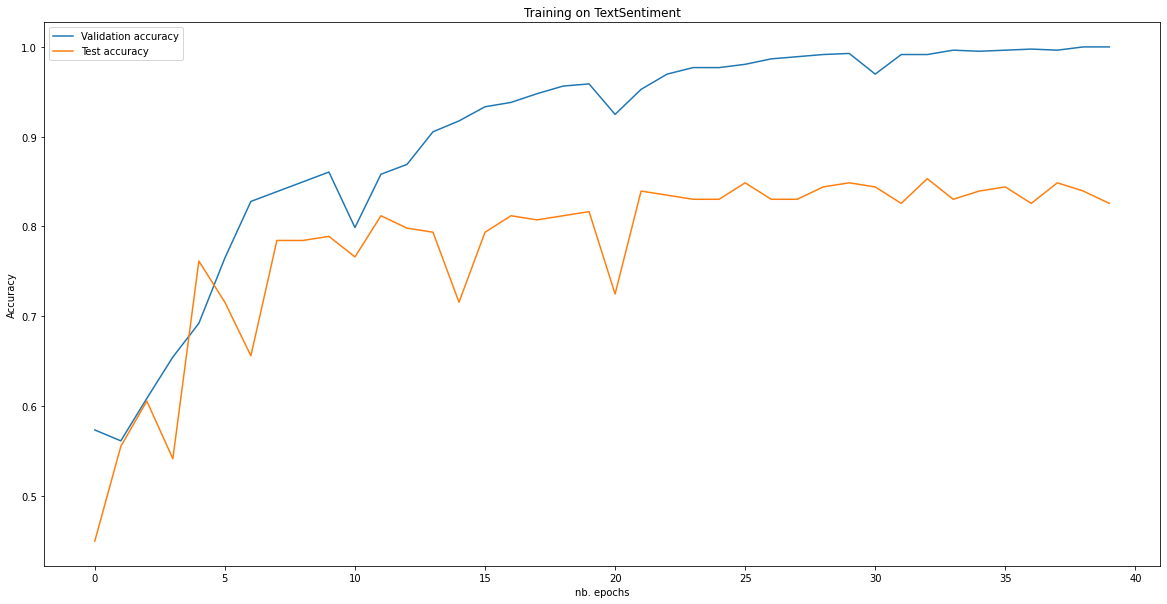

In [29]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))


plt.plot(train_score, label="Validation accuracy")
plt.plot(test_score, label="Test accuracy")
plt.xlabel("nb. epochs")
plt.ylabel("Accuracy")
plt.title("Training on TextSentiment")
plt.legend()
plt.show()

## Testing ##

In [26]:

print('Checking the results of test dataset...')
test_loss, test_acc = test(test_dataset)
print(f'\tLoss: {test_loss:.4f}(test)\t|\tAcc: {test_acc * 100:.1f}%(test)')


Checking the results of test dataset...
	Loss: 0.0000(test)	|	Acc: 87.2%(test)


In [126]:
model.predict(pd.read_csv("./data/test_2.csv", delimiter=","), vocab)

218lines [00:00, 580.81lines/s]


(tensor([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
          14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
          28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,
          42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,
          56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,
          70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,
          84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,
          98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111,
         112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125,
         126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139,
         140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153,
         154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167,
         168, 169, 170, 171, 172, 173, 174, 175, 176

## For storing model ##

In [127]:
with open('model.pkl', 'wb') as f1:
    pickle.dump(model, f1)

In [128]:
with open('vocab.pkl', 'wb') as f1:
    pickle.dump(vocab, f1)

## To send to Kristjan ##